In [1]:
! pip install category_encoders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from category_encoders import BinaryEncoder
from sklearn.dummy import DummyRegressor

In [3]:
df = pd.read_csv(filepath_or_buffer='rome_listings_aftereda.csv')

In [4]:
df.columns

Index(['neighbourhood_cleansed', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bathrooms_shared',
       'logprice'],
      dtype='object')

In [5]:
## One Hot encoding for room_type
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type')
df = pd.get_dummies(df, columns=['neighbourhood_cleansed'], prefix='neighbourhood')

In [6]:
## convert boolean columns to int
bool_cols = df.columns[df.dtypes == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

In [7]:
binary_encoder = BinaryEncoder()
binary_encoder.fit_transform(df['property_type'])
# Create a DataFrame with the new columns
new_columns = pd.DataFrame(binary_encoder.transform(df['property_type']), columns=binary_encoder.get_feature_names_out())

# Concatenate the new columns with the original dataset
df = pd.concat([df, new_columns], axis=1)
df.drop(columns=['property_type'], inplace=True)

In [8]:
new_columns

,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5
0,0,0,0,0,0,1
1,0,0,0,0,1,0
2,0,0,0,0,1,1
3,0,0,0,1,0,0
4,0,0,0,0,1,1
...,...,...,...,...,...,...
22812,0,0,0,0,1,1
22813,0,0,0,1,0,1
22814,0,0,0,0,1,1
22815,0,0,0,0,1,1


In [9]:
price = df.pop('logprice')

<Axes: >

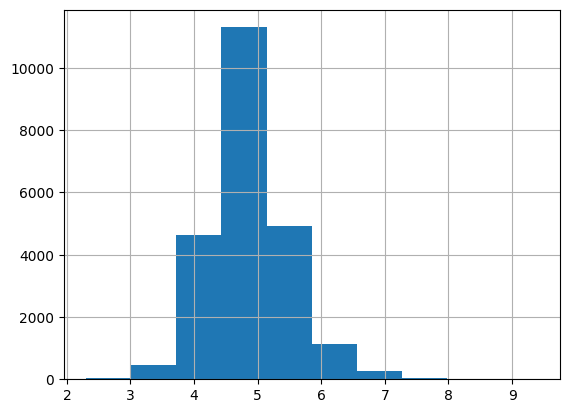

In [10]:
price.hist()

In [11]:
df.columns

Index(['longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bathrooms_shared', 'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_I Centro Storico', 'neighbourhood_II Parioli/Nomentano',
       'neighbourhood_III Monte Sacro', 'neighbourhood_IV Tiburtina',
       'neighbourhood_IX Eur', 'neighbourhood_V Prenestino/Centocelle',
       'neighbourhood_VI Roma delle Torri',
       'neighbourhood_VII San Giovanni/Cinecittà',
       'neighbourhood_VIII Appia Antica', 'neighbourhood_X Ostia/Acilia',
       'neighbourhood_XI Arvalia/Portuense', 'neighbourhood_XII Monte Verde',
       'neighbourhood_XIII Aurelia', 'neighbourhood_XIV Monte Mario',
       'neighbourhood_XV Cassia/Flaminia', 'property_type_0',
       'property_type_1', 'property_type_2', 'property_type_3',
       'property_type_4', 'property_type_5'],
      dtype='object')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, price, test_size=0.3, random_state=42, shuffle=True)

In [13]:
columns_to_standardize = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
scaler = StandardScaler()
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

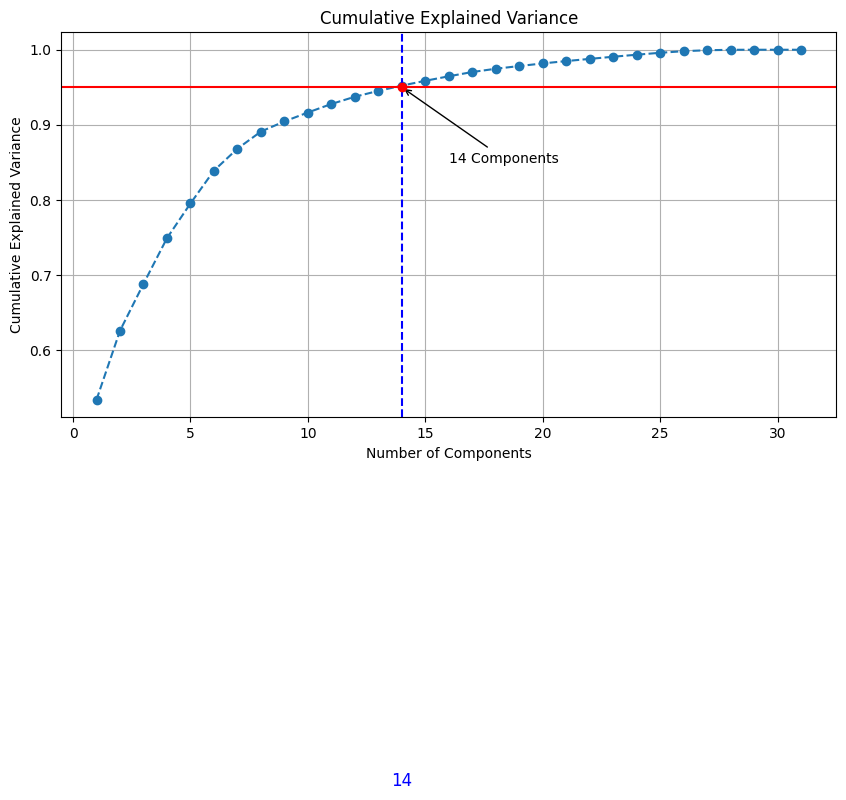

Number of components chosen: 14


In [14]:
# Step 3: Perform PCA
threshold = 0.95
pca = PCA().fit(X_train)

# Step 4: Calculate explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Step 5: Plot the cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-')
n_components = np.argmax(cumulative_variance >= threshold) + 1
plt.axvline(x=n_components, color='b', linestyle='--')

# Annotations
plt.annotate(f'{n_components} Components',
             xy=(n_components, threshold),
             xytext=(n_components + 2, threshold - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)
plt.text(n_components, 0.02, f'{n_components}', color='blue', ha='center', fontsize=12)
plt.scatter(n_components, threshold, color='red', zorder=5)

# Labels and title
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

print(f"Number of components chosen: {n_components}")

In [15]:
pca = PCA(n_components=n_components)
X_train_transform = pca.fit_transform(X_train)
X_test_transform = pca.transform(X_test)

In [16]:
X_train_transform.shape

(15971, 14)

In [17]:
# Linear Regression
param_grid = {}
scoring = make_scorer(mean_squared_error, greater_is_better=False)
model = LinearRegression()
grid_search_linreg = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_linreg.fit(X_train_transform, y_train)
# print("Best parameters found: ", grid_search_linreg.best_params_)
print("Best mean squared error: ", -grid_search_linreg.best_score_)

Best mean squared error:  0.21732054606994308


In [18]:
# Ridge Regression
alphas = np.logspace(-6, 6, 100, base=10)
param_grid = {'alpha': alphas}
scoring = make_scorer(mean_squared_error, greater_is_better=False)
model = Ridge()
grid_search_ridge = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_ridge.fit(X_train, y_train)
print("Best parameters found: ", grid_search_ridge.best_params_)
print("Best mean squared error: ", -grid_search_ridge.best_score_)


Best parameters found:  {'alpha': 2.656087782946689}
Best mean squared error:  0.21206892887488146


In [19]:
# Lasso
alphas = np.logspace(-6, 6, 100, base=10)
param_grid = {'alpha': alphas}
model = Lasso()
grid_search_lasso = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_lasso.fit(X_train, y_train)
print("Best parameters found: ", grid_search_lasso.best_params_)
print("Best mean squared error: ", -grid_search_lasso.best_score_)

/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.418e+02, tolerance: 5.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.293e+02, tolerance: 5.095e-01
  model = cd_fast.enet_coordinate_descent(
/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Conver

Best parameters found:  {'alpha': 4.977023564332114e-05}
Best mean squared error:  0.21207169826711417


In [20]:
# Decision Tree
param_grid = param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'ccp_alpha': [0.0, 0.1, 0.2],
    'random_state': [2]  # Adjust this according to your needs
}
model = DecisionTreeRegressor()
grid_search_dt = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1,
    verbose=1
)
grid_search_dt.fit(X_train, y_train)
print("Best parameters found: ", grid_search_dt.best_params_)
print("Best mean squared error: ", -grid_search_dt.best_score_)

Fitting 5 folds for each of 2430 candidates, totalling 12150 fits
Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': 10, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'random_state': 2, 'splitter': 'random'}
Best mean squared error:  0.2107166101082211


In [21]:
# Random Forest
param_grid = param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
model = RandomForestRegressor()
grid_search_rf = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train, y_train)
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best mean squared error: ", -grid_search_rf.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/home/lorenzobonanni/Desktop/UNI/MAGISTRALE/STATISTICAL LEARNING/PROGETTO/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best mean squared error:  0.18958961546730124


In [22]:
# XGBoost
param_grid = param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
}
model = xgb.XGBRegressor(random_state=2)
grid_search_xgb = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=KFold(5, random_state=2, shuffle=True),
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best mean squared error: ", -grid_search_xgb.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 100}
Best mean squared error:  0.18766740112463093


In [23]:
dummy_reg_mean = DummyRegressor(strategy='mean')
dummy_reg_mean.fit(X_train, y_train)

DummyRegressor()

In [24]:
# Evaluate the best model
performance = {}
trained = {
    'Ridge': grid_search_ridge.best_estimator_,
    'Lasso': grid_search_lasso.best_estimator_,
    'DecisionTree': grid_search_dt.best_estimator_,
    'RandomForest': grid_search_rf.best_estimator_,
    'XGBoost': grid_search_xgb.best_estimator_,
    'Dummy_mean': dummy_reg_mean
}
for name, model in trained.items():
    predictions = model.predict(X_test)
    mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
    rmse = np.sqrt(mse)
    r_squared = r2_score(np.exp(y_test), np.exp(predictions))
    performance[name] = mse
    print(f"{name} mean squared error: {mse}", f"root mean squared error: {rmse}", f"R^2: {r_squared}")

Ridge mean squared error: 92144.2351404446 root mean squared error: 303.5526892327666 R^2: 0.029897858568767477
Lasso mean squared error: 92130.91210937813 root mean squared error: 303.5307432689119 R^2: 0.030038124543608213
DecisionTree mean squared error: 86278.05307294973 root mean squared error: 293.7312599519325 R^2: 0.09165750937088724
RandomForest mean squared error: 85405.18922614142 root mean squared error: 292.2416623723274 R^2: 0.10084709226422839
XGBoost mean squared error: 84429.44238431088 root mean squared error: 290.5674489413962 R^2: 0.11111983585271024
Dummy_mean mean squared error: 96684.84486010062 root mean squared error: 310.94186733230475 R^2: -0.017906056735624398


In [25]:
model = grid_search_linreg.best_estimator_
name = "PCA + Linear Regression"
X_test_transform = pca.transform(X_test)
predictions = model.predict(X_test_transform)
mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
rmse = np.sqrt(mse)
r_squared = r2_score(np.exp(y_test), np.exp(predictions))
performance[name] = mse
print(f"{name} mean squared error: {mse}", f"root mean squared error: {rmse}", f"R^2: {r_squared}")

Linear Regression mean squared error: 91559.0253662315 root mean squared error: 302.58721943636596 R^2: 0.03605899555455194


PCA + Linear Regression mean squared error: 91559.0253662315 root mean squared error: 302.58721943636596 R^2: 0.03605899555455194
Ridge mean squared error: 92144.2351404446 root mean squared error: 303.5526892327666 R^2: 0.029897858568767477
DecisionTree mean squared error: 86278.05307294973 root mean squared error: 293.7312599519325 R^2: 0.09165750937088724
RandomForest mean squared error: 85405.18922614142 root mean squared error: 292.2416623723274 R^2: 0.10084709226422839
XGBoost mean squared error: 84429.44238431088 root mean squared error: 290.5674489413962 R^2: 0.11111983585271024
Dummy_mean mean squared error: 96684.84486010062 root mean squared error: 310.94186733230475 R^2: -0.017906056735624398
                                  MSE       R^2
PCA + Linear Regression  91559.025366  0.036059
Ridge                    92144.235140  0.029898
DecisionTree             86278.053073  0.091658
RandomForest             85405.189226  0.100847
XGBoost                  84429.442384  0.11112

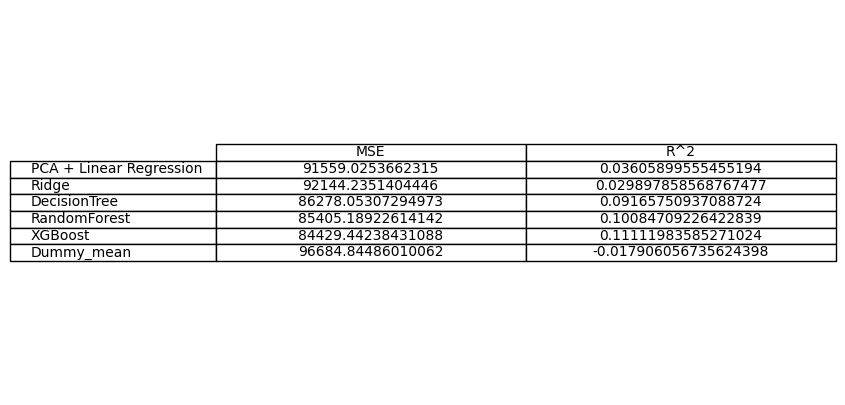

In [54]:
import matplotlib.table as tbl

# Dictionary to store performance metrics
performance = {}

# Evaluate performance for PCA + Linear Regression model separately
model = grid_search_linreg.best_estimator_
name = "PCA + Linear Regression"
X_test_transform = pca.transform(X_test)
predictions = model.predict(X_test_transform)
mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
rmse = np.sqrt(mse)
r_squared = r2_score(np.exp(y_test), np.exp(predictions))
performance[name] = {'MSE': mse, 'R^2': r_squared}
print(f"{name} mean squared error: {mse}", f"root mean squared error: {rmse}", f"R^2: {r_squared}")

# Dictionary of trained models in the specified order
trained = {
    'Ridge': grid_search_ridge.best_estimator_,
    'DecisionTree': grid_search_dt.best_estimator_,
    'RandomForest': grid_search_rf.best_estimator_,
    'XGBoost': grid_search_xgb.best_estimator_,
    'Dummy_mean': dummy_reg_mean
}

# Evaluate performance for each model in 'trained'
for name, model in trained.items():
    predictions = model.predict(X_test)
    mse = mean_squared_error(np.exp(y_test), np.exp(predictions))
    rmse = np.sqrt(mse)
    r_squared = r2_score(np.exp(y_test), np.exp(predictions))
    performance[name] = {'MSE': mse, 'R^2': r_squared}
    print(f"{name} mean squared error: {mse}", f"root mean squared error: {rmse}", f"R^2: {r_squared}")


# Convert the performance dictionary to a DataFrame
performance_df = pd.DataFrame(performance).T
print(performance_df)

# Create a table and save it as an image
fig, ax = plt.subplots(figsize=(8, 5))  # set size frame
ax.axis('tight')
ax.axis('off')
table = tbl.table(ax, cellText=performance_df.values, colLabels=performance_df.columns, rowLabels=performance_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1)

plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()



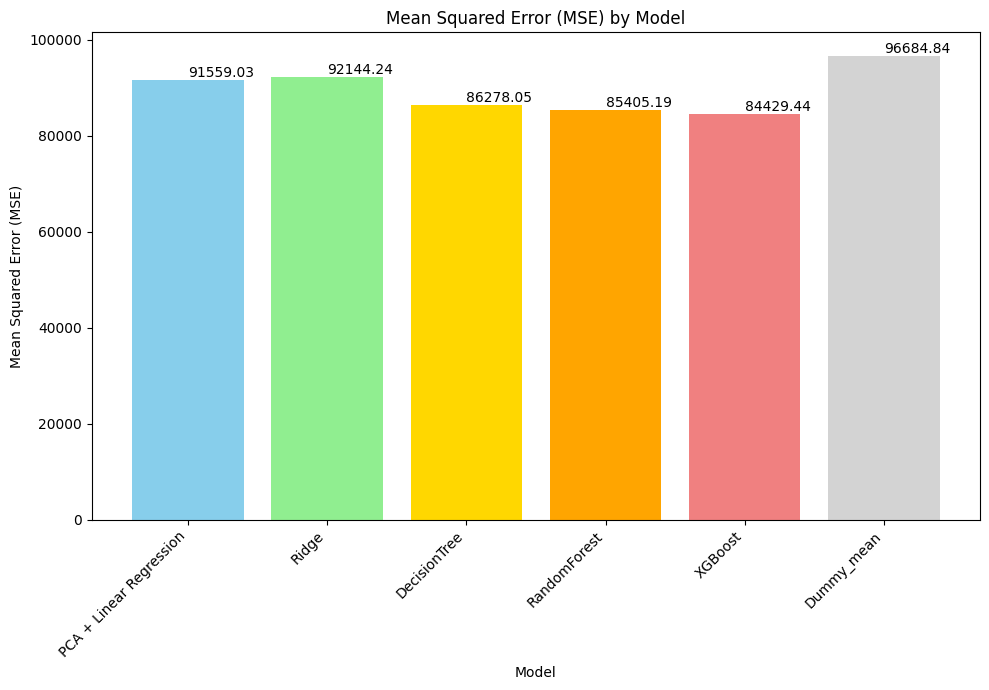

In [48]:
plt.figure(figsize=(10, 7))
bars = plt.bar(performance_df.index, performance_df['MSE'], color=['skyblue', 'lightgreen', 'gold','orange','lightcoral','lightgrey'])

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) by Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

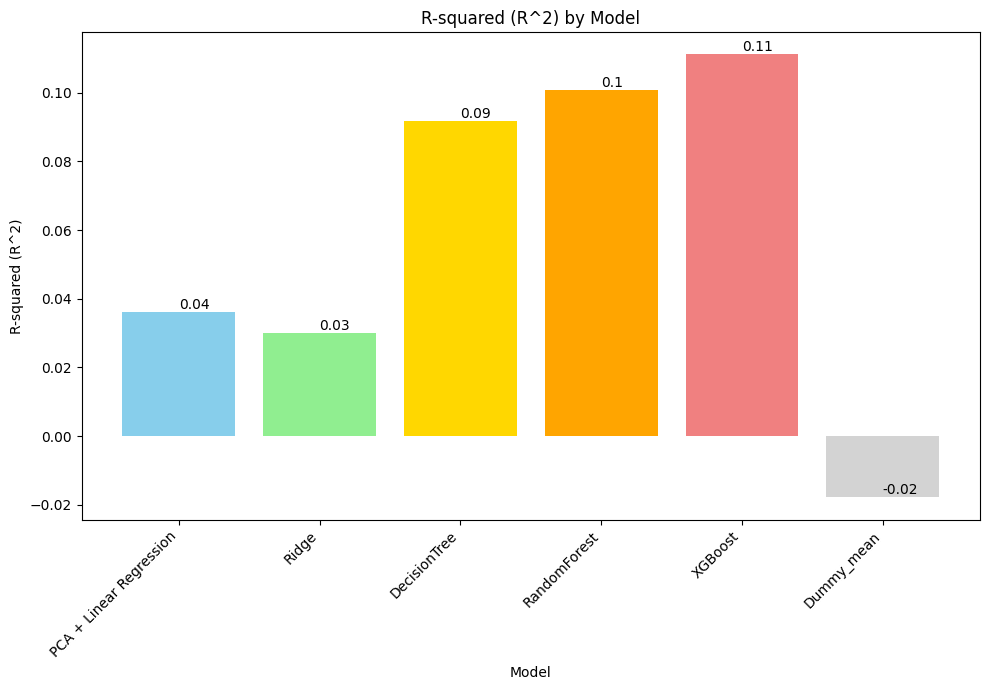

In [49]:
# Plotting R-squared
plt.figure(figsize=(10, 7))
bars = plt.bar(performance_df.index, performance_df['R^2'], color=['skyblue', 'lightgreen', 'gold','orange','lightcoral','lightgrey'])

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.xlabel('Model')
plt.ylabel('R-squared (R^2)')
plt.title('R-squared (R^2) by Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


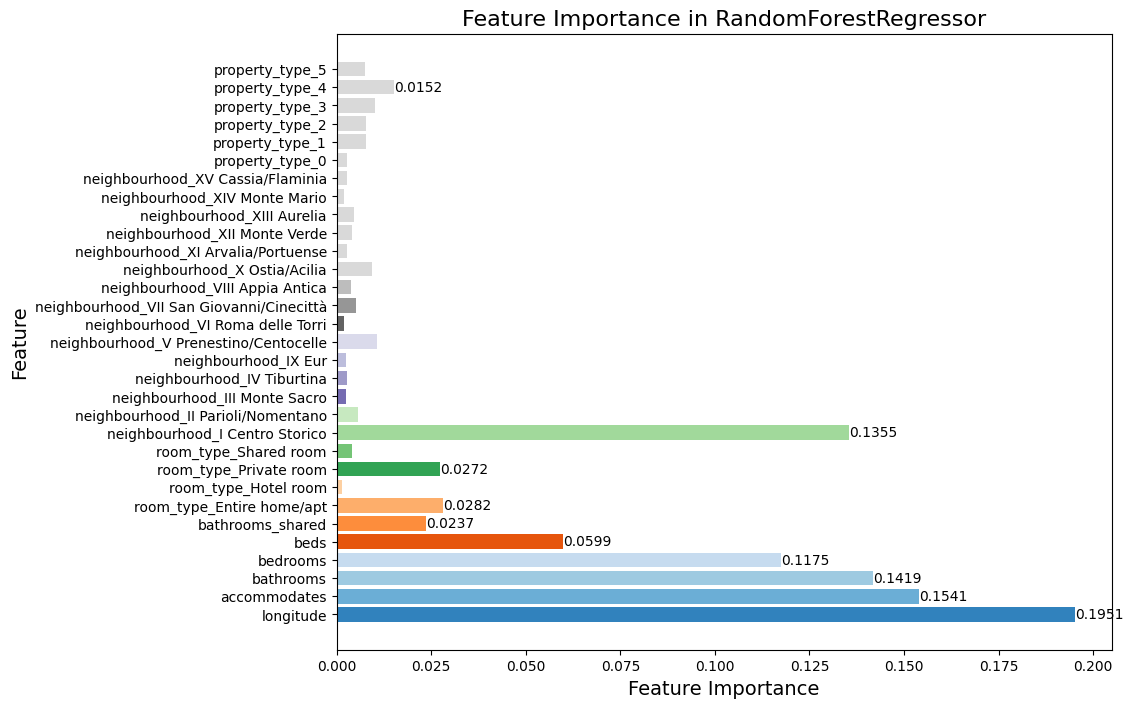

In [53]:
importances = grid_search_rf.best_estimator_.feature_importances_
feature_names = X_train.columns

# Plot the feature importances
plt.figure(figsize=(10, 8))

# Selecting a colormap with distinct colors
colormap = plt.cm.tab20c

# Plotting each bar with a different color
bars = plt.barh(feature_names, importances, color=[colormap(i) for i in range(len(feature_names))])

# Add text annotations for values > 0.015
for bar, imp in zip(bars, importances):
    if imp > 0.015:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, round(imp, 4), va='center')

plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance in RandomForestRegressor', fontsize=16)
plt.show()